# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier



---
## Step 0: Load The Data

In [1]:
# Load pickled data
import pickle, csv
import math
import tensorflow as tf
import numpy as np
import cv2
import matplotlib.pyplot as plt
import random
from statistics import mean
from tensorflow.contrib.layers import flatten

# Visualizations will be shown in the notebook.
%matplotlib inline


plt.ion()

# TODO: Fill this in based on where you saved the training and testing data

training_file = '../data/train.p'
validation_file= '../data/valid.p'
testing_file = '../data/test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']



labelName = {}
with open('signnames.csv') as namesFile:
    rows = csv.DictReader(namesFile)
    for row in rows:
        labelName[int(row["ClassId"])]=row["SignName"]

#print(labelName[0])


X_train_orig = X_train.copy()
Y_train_orig = y_train.copy()
X_valid_orig = X_valid.copy()
X_test_orig = X_test.copy()


---

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 1D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**


### Basic Summary of the Data Set Using Python, Numpy and/or Pandas

In [2]:
### Replace each question mark with the appropriate value. 
### Use python, pandas or numpy methods rather than hard coding the results

# TODO: Number of training examples
n_train = len(X_train)

# TODO: Number of validation examples
n_validation = len(X_valid)

# TODO: Number of testing examples.
n_test = len(X_test)

# TODO: What's the shape of an traffic sign image?
image_shape = X_train[0].shape

# TODO: How many unique classes/labels there are in the dataset.
n_classes = len(set(list(y_train) + list(y_valid) + list(y_test)))

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 34799
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


### Include an exploratory visualization of the dataset

Visualize the German Traffic Signs Dataset using the pickled file(s). This is open ended, suggestions include: plotting traffic sign images, plotting the count of each sign, etc. 


Plotting 15 random Images from each class...


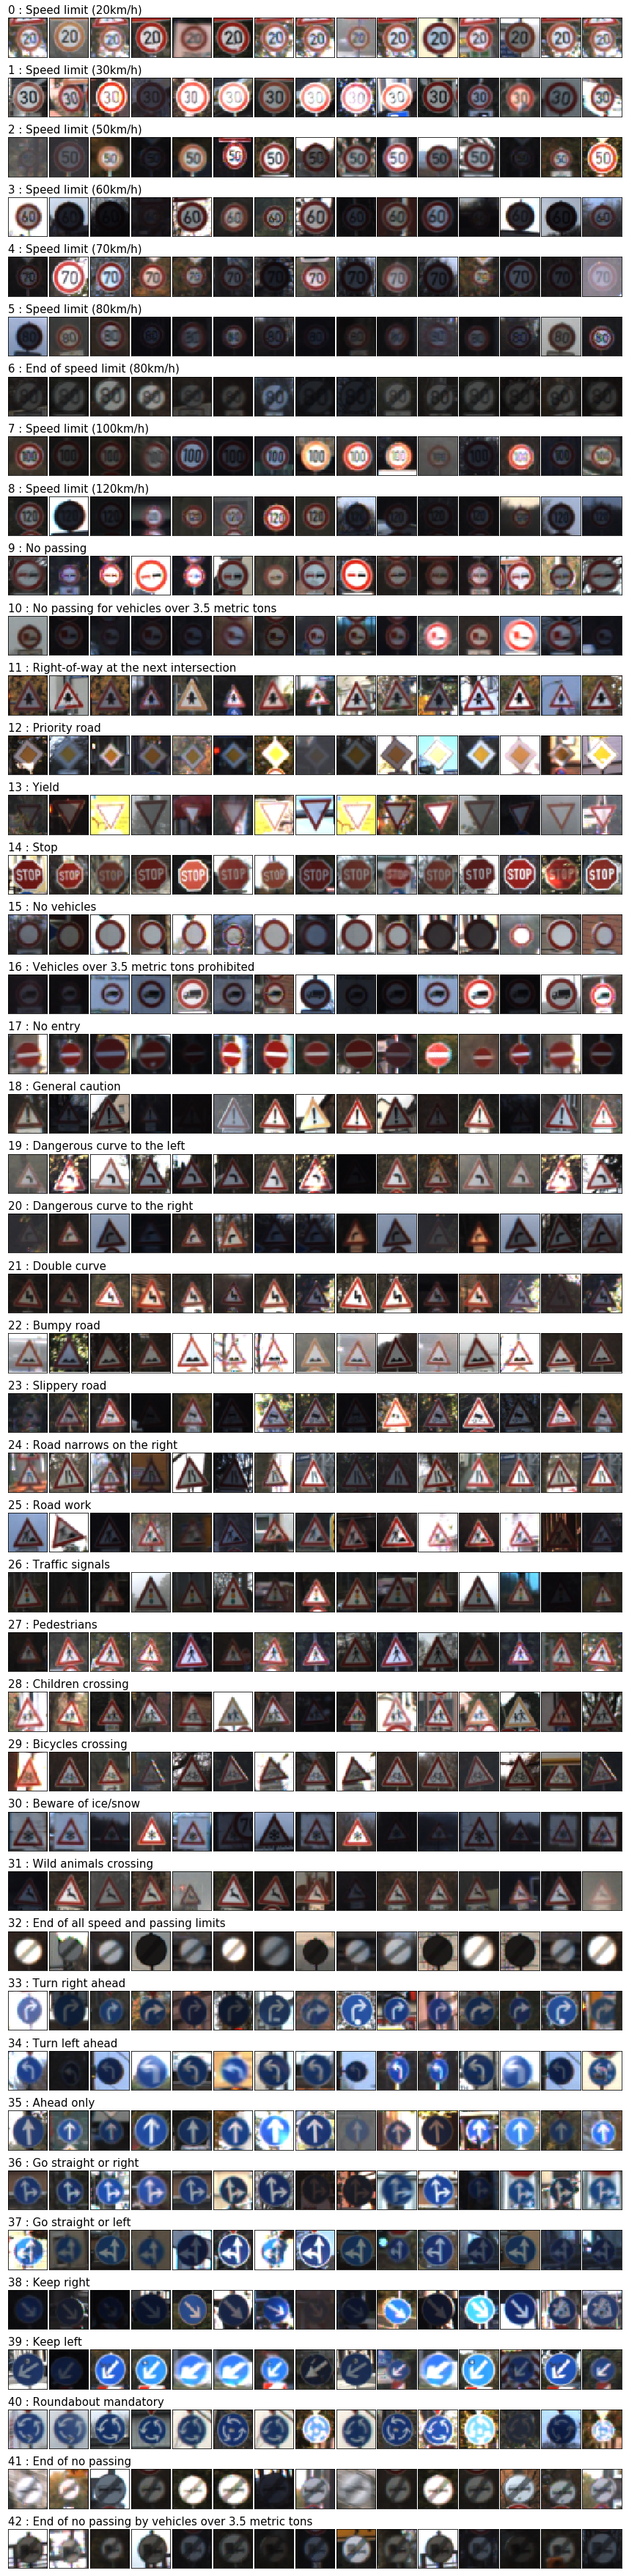

In [3]:
### Data exploration visualization code goes here.

print("Plotting 15 random Images from each class...")
fig, axs = plt.subplots(n_classes,15, figsize=(15, 1.5*n_classes))
for shield_no in range(0, n_classes):
    #print (shield_no)
    shield = y_train.copy()
    shield_inds = np.nonzero(shield==shield_no)
    rand_index=random.sample(range(0, len(shield_inds[0])), 15)
    
    axs[shield_no, 0].set_title("{0} : {1}".format(shield_no, labelName[shield_no]), fontsize=15, x=0, ha='left')
    plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.05, hspace=0)
    for i in range(0, 15):
        axs[shield_no, i].imshow(X_train[shield_inds[0][rand_index[i]]])
        axs[shield_no, i].get_xaxis().set_visible(False)
        axs[shield_no, i].get_yaxis().set_visible(False)
    #plt.close()
    
plt.savefig('outImages/InputVisual.jpg', bbox_inches='tight')

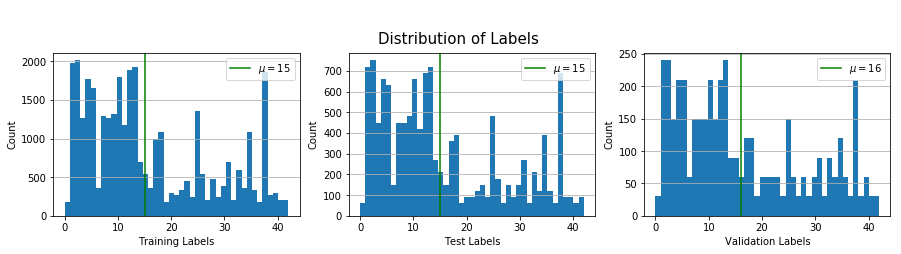

In [4]:

#Plot distribution of labels in train, test
fig, axs = plt.subplots(1,3, figsize=(15, 3))
fig.suptitle("Distribution of Labels", fontsize=15)
label = [y_train, y_test, y_valid]
title=['Training Labels', 'Test Labels', 'Validation Labels']
for i,ax in enumerate(axs.flat):
    n, bins, patches = ax.hist(label[i], n_classes)
    ax.axvline(x=mean(label[i]), color='g', label="$\mu = {0}$".format(mean(label[i])))
    ax.set_xlabel(title[i])
    ax.set_ylabel('Count')
    ax.set_title(" \n\n")  
    ax.yaxis.grid()
    ax.legend()
plt.savefig('outImages/DistributionOfLabels.jpg', bbox_inches='tight')

----

## Step 2: Design and Test a Model Architecture

We use LeNet-5 model. 

### Pre-process the Data Set (normalization, grayscale, etc.)

The image data is normalized so that the data has mean zero and equal variance by employing `(pixel - 128)/ 128`.
Also we convert the images to grayscale and use 32x32x1 dimensions instead of 32x32x3 per image.

In [5]:
def redim(images):
    output = np.zeros((len(images), 32, 32, 1), np.float64)
    for i,img in enumerate(images):
        output[i] = np.reshape(img, img.shape + (1,))
        output[i] = (output[i].astype(np.float64) - 128)/128
    return output

def preprocess(images):
    output = np.zeros((len(images), 32, 32), np.float64)
    for i, img in enumerate(images):
        output[i] = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    return output




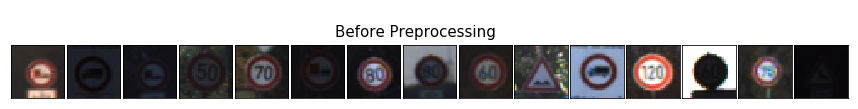

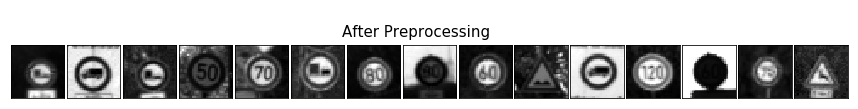

In [6]:
from sklearn.utils import shuffle

y_train = Y_train_orig.copy()
X_train = preprocess(X_train_orig)
X_train_preped = X_train.copy()
Y_train_preped = Y_train_orig.copy()
X_train = redim(X_train)
X_valid = redim(preprocess(X_valid_orig))
X_test = redim(preprocess(X_test_orig))
X_train, y_train = shuffle(X_train, y_train)

# Plot Sample training images after preprocessing
rand_samples = 15
fig, axs = plt.subplots(1,15, figsize=(15, 1.9))
fig.suptitle("\nBefore Preprocessing", fontsize=15)
rand_index=random.sample(range(0, n_train), rand_samples)
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.05, hspace=0)
for i,ax in enumerate(axs.flat):
    ax.imshow(X_train_orig[rand_index[i]])
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    #name_of_sign=labelName[Y_train_preped[rand_index[i]]]
    #label_of_sign = y_train[rand_index[i]]
    #ax.set_title("{0}\n[index: {1}, label={2}]".format(name_of_sign, rand_index[i], label_of_sign))
plt.savefig('outImages/b4Preprocess.jpg', bbox_inches='tight')

# Plot Sample training images after preprocessing
fig, axs = plt.subplots(1,15, figsize=(15, 1.9))
fig.suptitle("\nAfter Preprocessing", fontsize=15)
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.05, hspace=0)
for i,ax in enumerate(axs.flat):
    ax.imshow(X_train_preped[rand_index[i]], cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    #name_of_sign=labelName[Y_train_preped[rand_index[i]]]
    #label_of_sign = y_train[rand_index[i]]
    #ax.set_title("{0}\n[index: {1}, label={2}]".format(name_of_sign, rand_index[i], label_of_sign))
plt.savefig('outImages/afterPreprocess.jpg', bbox_inches='tight')


### Model Architecture

In [7]:
### Architecture defined here.
EPOCHS = 40
BATCH_SIZE = 128
modelLocation = './models/traffic_sign_model'
doTrain = True

mu = 0
sigma = 0.1

# randomly defines variables for the weights and biases for each layer
weights = {
    'wl1c': tf.Variable(tf.truncated_normal(shape=(5, 5, 1, 16), mean = mu, stddev = sigma)),
    'wl2c': tf.Variable(tf.truncated_normal(shape=(5, 5, 16, 64), mean = mu, stddev = sigma)),
    'wl3f': tf.Variable(tf.truncated_normal(shape=(1600, 240), mean = mu, stddev = sigma)),
    'wl4f': tf.Variable(tf.truncated_normal(shape=(240,84), mean = mu, stddev = sigma)),
    'wl5f': tf.Variable(tf.truncated_normal(shape=(84, 43), mean = mu, stddev = sigma))
}

biases = {
    'bl1': tf.Variable(tf.zeros([16])),
    'bl2': tf.Variable(tf.zeros([64])),
    'bl3': tf.Variable(tf.zeros([240])),
    'bl4': tf.Variable(tf.zeros([84])),
    'bl5': tf.Variable(tf.zeros([43]))}



def LeNet(x):    
    
    # Layer 1: Convolutional. Input = 32x32x1. Output = 28x28x16.
    # applying conv of 5x5 with Padding = zero (VALID), and stride = 1
    x = tf.nn.conv2d(x, weights['wl1c'], strides=[1, 1, 1, 1], padding='VALID')
    tf.nn.bias_add(x, biases['bl1'])

    # Activation.
    x = tf.nn.relu(x)

    # Pooling. Input = 28x28x16. Output = 14x14x16.
    # kernel size is 2x2 
    x = tf.nn.max_pool(x, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    # Layer 2: Convolutional. Input = 14x14x16, Output = 10x10x64.
    # applying conv of 5x5 with Padding = zero (VALID), and stride = 1
    x = tf.nn.conv2d(x, weights['wl2c'], strides=[1, 1, 1, 1], padding='VALID')
    tf.nn.bias_add(x, biases['bl2'])
    
    # Activation.
    x = tf.nn.relu(x)

    # Pooling. Input = 10x10x64. Output = 5x5x64.
    # kernel size is 2x2 
    x = tf.nn.max_pool(x, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    # Flatten. Input = 5x5x64. Output = 1600.
    x = tf.contrib.layers.flatten(x)
    
    # Layer 3: Fully Connected. Input = 1600. Output = 240.
    x = tf.add(tf.matmul(x, weights['wl3f']), biases['bl3'])
    
    # Activation.
    x = tf.nn.relu(x)
    
    # Dropout
    x = tf.nn.dropout(x, keep_prob)

    # Layer 4: Fully Connected. Input = 240. Output = 84.
    x = tf.add(tf.matmul(x, weights['wl4f']), biases['bl4'])
    
    # Activation.
    x = tf.nn.relu(x)
    
    # Dropout
    x = tf.nn.dropout(x, keep_prob)

    # Layer 5: Fully Connected. Input = 84. Output = 43.
    logits = tf.add(tf.matmul(x, weights['wl5f']), biases['bl5'])
 
    return logits




### Train, Validate and Test the Model

A validation set can be used to assess how well the model is performing. A low accuracy on the training and validation
sets imply underfitting. A high accuracy on the training set but low accuracy on the validation set implies overfitting.

In [8]:
### Train your model here.
### Calculate and report the accuracy on the training and validation set.
### Once a final model architecture is selected, 
### the accuracy on the test set should be calculated and reported as well.
### Feel free to use as many code cells as needed.

x = tf.placeholder(tf.float32, (None, 32, 32, 1))
y = tf.placeholder(tf.int32, (None))
keep_prob = tf.placeholder(tf.float32)
one_hot_y = tf.one_hot(y, 43)

#curr_per_class_right_pred=np.zeros([n_classes])

rate = 0.001

logits = LeNet(x)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=one_hot_y, logits=logits)
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate = rate)
training_operation = optimizer.minimize(loss_operation)

correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
per_class_right_pred_op = tf.cast(correct_prediction, tf.float32)
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver = tf.train.Saver()

def evaluate(X_data, y_data):
    classwise_errors = np.zeros([n_classes])
    classwise_samples = np.zeros([n_classes])
    classwise_error_sample_ratio = np.zeros([n_classes], dtype=np.float64)
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y, keep_prob: 1.0})
        total_accuracy += (accuracy * len(batch_x))
        batch_correct_predictions = sess.run(per_class_right_pred_op, feed_dict={x: batch_x, y: batch_y, keep_prob: 1.0})
        batch_wrong_predictions_index=np.nonzero(batch_correct_predictions==0)[0]
        wrong_predics_class_index = (batch_y[batch_wrong_predictions_index])

        for i in wrong_predics_class_index:
            classwise_errors[i] += 1
        
        for i in y_data:
            classwise_samples[i] += 1
    
    classwise_error_sample_ratio = np.divide(classwise_errors, classwise_samples)
    #print (max(classwise_error_sample_ratio))
        
        #print (classwise_errors)
    return total_accuracy / num_examples, classwise_error_sample_ratio

In [9]:
bars = None
def plotAccuracy(fig, axes, epoch_validation, classwise_errors):
    global bars    
    accuracy_data = epoch_validation[np.nonzero(epoch_validation)]
    x_data = range(1, len(accuracy_data)+1)
    
    if (axes[0].lines):
        axes[0].lines[0].set_xdata(x_data)
        axes[0].lines[0].set_ydata(accuracy_data)
        #axes[1].bar(range(1, len(classwise_errors)+1), classwise_errors, color='b')
        for bar,h in zip(bars, classwise_errors):
            bar.set_height(h)
        
        
    else:
        axes[0].plot(range(1,len(epoch_validation)+1), epoch_validation,'g-')
        axes[0].grid(True)
        axes[0].set_xlim([1, len(epoch_validation)])
        axes[0].set_ylim([0.8, 1])
        axes[0].set_title('Validation Accuracy per Epoch', fontsize=15)
        axes[0].set_xlabel('Epochs')
        axes[0].set_ylabel('Accuracy')
        
        axes[1].set_title('Mean Classwise Errors to Samples Ratio', fontsize=15)
        bars = axes[1].bar(range(0, len(classwise_errors)), classwise_errors)
        axes[1].grid(True)
        axes[1].set_ylim([0, .025])
        axes[1].set_xlim([-1, len(classwise_errors)])
        #axes[1].set_xlim([1, len(accuracy_data)+1])
        
    
    fig.canvas.draw()
 

Training ...


<IPython.core.display.Javascript object>


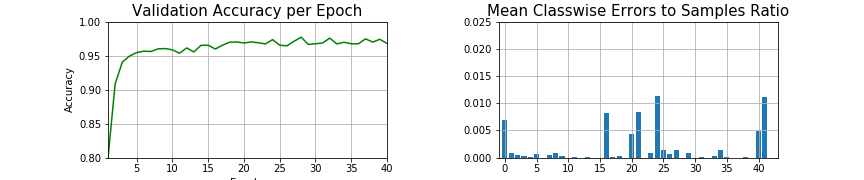

Training finished
Accuracy: Train: 1.000, Validation: 0.968, Test: 0.950


<IPython.core.display.Javascript object>


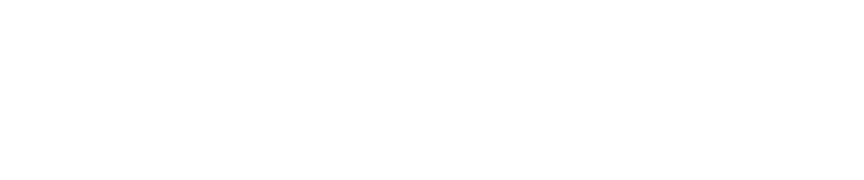

In [10]:
#from ipywidgets import IntProgress
#from IPython.display import display
%matplotlib notebook   
epoch_validation = np.zeros((EPOCHS), dtype=np.float64)
cum_classwise_errors=np.zeros([5, n_classes],dtype=np.float64)

test_accuracy = 0.0
if doTrain:
 
    print("Training ...")
#    f = IntProgress(min=0, max=EPOCHS) # instantiate the bar
#    display(f) # display the bar
    
    fig, axes = plt.subplots(ncols=2, figsize=(12, 2.5))
    plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.4, hspace=0)
    plotAccuracy(fig, axes, epoch_validation, np.mean(cum_classwise_errors,0))
    

    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        num_examples = len(X_train)
        validation_accuracy = 0.0
        
        for i in range(EPOCHS):
            #f.value = i
            #print (" Epoch {0} of {1}".format(i,EPOCHS))
            X_train, y_train = shuffle(X_train, y_train)
            for offset in range(0, num_examples, BATCH_SIZE):
                end = offset + BATCH_SIZE
                batch_x, batch_y = X_train[offset:end], y_train[offset:end]
                sess.run(training_operation, feed_dict={x: batch_x, y: batch_y, keep_prob: 0.6})

            validation_accuracy, cum_classwise_errors[i%len(cum_classwise_errors)] = evaluate(X_valid, y_valid)
            epoch_validation[i] = validation_accuracy
            #cum_classwise_errors += classwise_errors
            plotAccuracy(fig, axes, epoch_validation, np.mean(cum_classwise_errors,0))

        train_accuracy = evaluate(X_train, y_train)[0]
        test_accuracy = evaluate(X_test, y_test)[0]
        print('Training finished')
        print('Accuracy: Train: {:.3f}, Validation: {:.3f}, Test: {:.3f}'\
                .format(train_accuracy, validation_accuracy, test_accuracy))
 #       f.value = EPOCHS
        #print ("Last Epoch classwise errors")
        #print (classwise_errors)
        saver.save(sess, modelLocation)
        plt.savefig('outImages/AccuracyPic.jpg', bbox_inches='tight')
else:
    print('No training configured')

---

## Step 3: Test a Model on New Images

The new pics for evaluating the developed model are captured from following videos: 
1. https://www.youtube.com/watch?v=QE03kKtJeWs
2. https://www.youtube.com/watch?v=Hx44jrWHaUE


### Load and Output the Images

In [11]:
import glob, os
%matplotlib inline

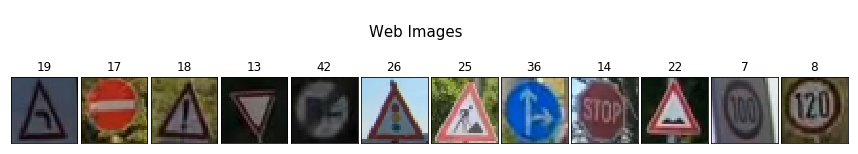

In [12]:
### Load the images and plot them here.
webImagesDir = 'webimages'
imgFiles = glob.glob('webimages/*.jpg')
sampleImages = []
y = []
#sampleImages = np.zeros([len(imgFiles), 32, 32, 3])
for i,imgFile in enumerate(imgFiles):
    img=cv2.cvtColor(cv2.imread(imgFile), cv2.COLOR_BGR2RGB)
    #img=(cv2.imread(imgFile))[...,::-1][...,::-1]
    img=cv2.resize(img, (32,32), interpolation = cv2.INTER_AREA)
    sampleImages.append(img)
    y.append(int(os.path.basename(imgFiles[i].split('.')[0]))) 

webImgs=np.array(sampleImages)
ys = np.array(y)

fig, axs = plt.subplots(1,12, figsize=(15, 3))
fig.suptitle("\nWeb Images", fontsize=15)
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.05, hspace=0)
for i,ax in enumerate(axs.flat):
    ax.imshow(webImgs[i])
    ax.set_title("{0}".format(ys[i]))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.savefig('outImages/webImages.jpg', bbox_inches='tight')

### Predict the Sign Type for Each Image

In [13]:
### Run the predictions here and use the model to output the prediction for each image.
X_webImgs = redim(preprocess(webImgs))

with tf.Session() as sess:
    saver.restore(sess, modelLocation)
    web_classes = sess.run(logits, feed_dict={x: X_webImgs, keep_prob : 1.0})
    web_softmax = sess.run(tf.nn.softmax(logits), feed_dict={x: X_webImgs, keep_prob : 1.0})

INFO:tensorflow:Restoring parameters from ./models/traffic_sign_model


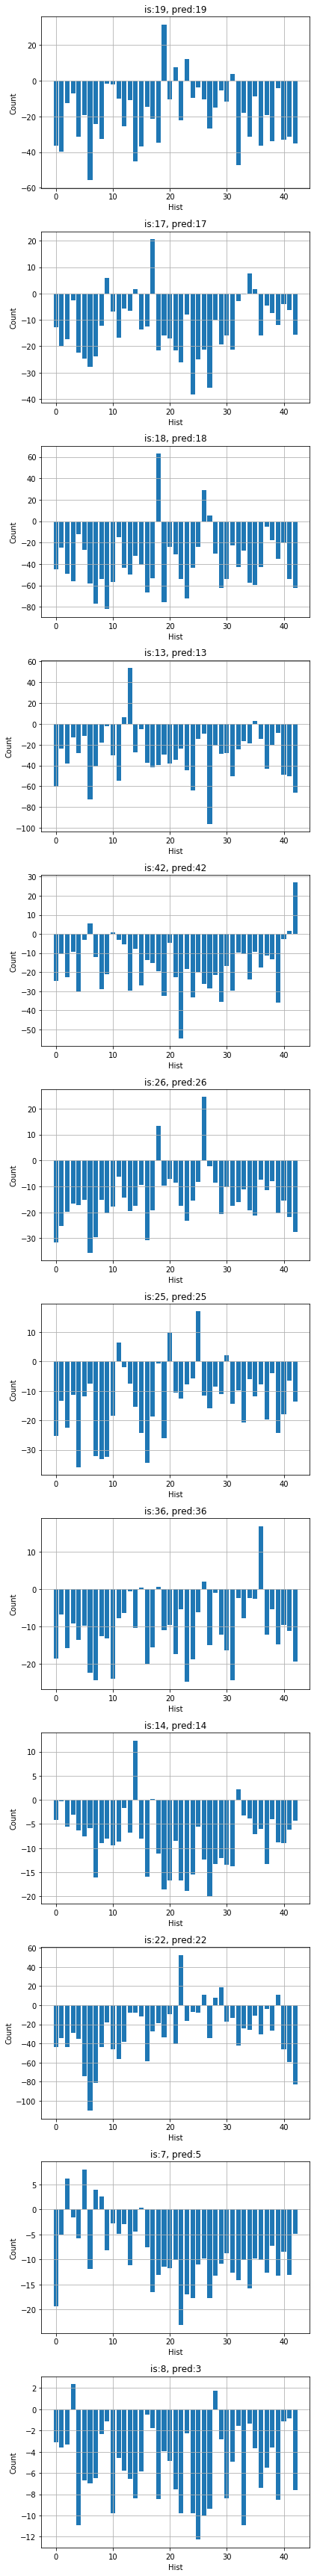

In [18]:
def plotOutput(classes, ys):
    """
    Plot the network output
    """
    nRows = len(classes)
 
    fig, axes = plt.subplots(nrows=nRows, figsize=(6, 4*nRows))
    for ax, aClass, y in zip(axes, classes, ys):        
        ax.bar(range(0,43), aClass)
        ax.set_xlabel('Hist')
        ax.set_ylabel('Count')
        ax.set_title("is:{0}, pred:{1}".format(y,np.argmax(aClass)))
        ax.grid(True)
        
    fig.tight_layout()
    plt.show()
    plt.savefig('outImages/predicHistoWeb.jpg', bbox_inches='tight')
plotOutput(web_classes, ys)

### Analyze Performance

In [15]:
### Calculate the accuracy for these 5 new images. 
with tf.Session() as sess:
    predics = sess.run(tf.nn.top_k(web_softmax, k=5, sorted=True))

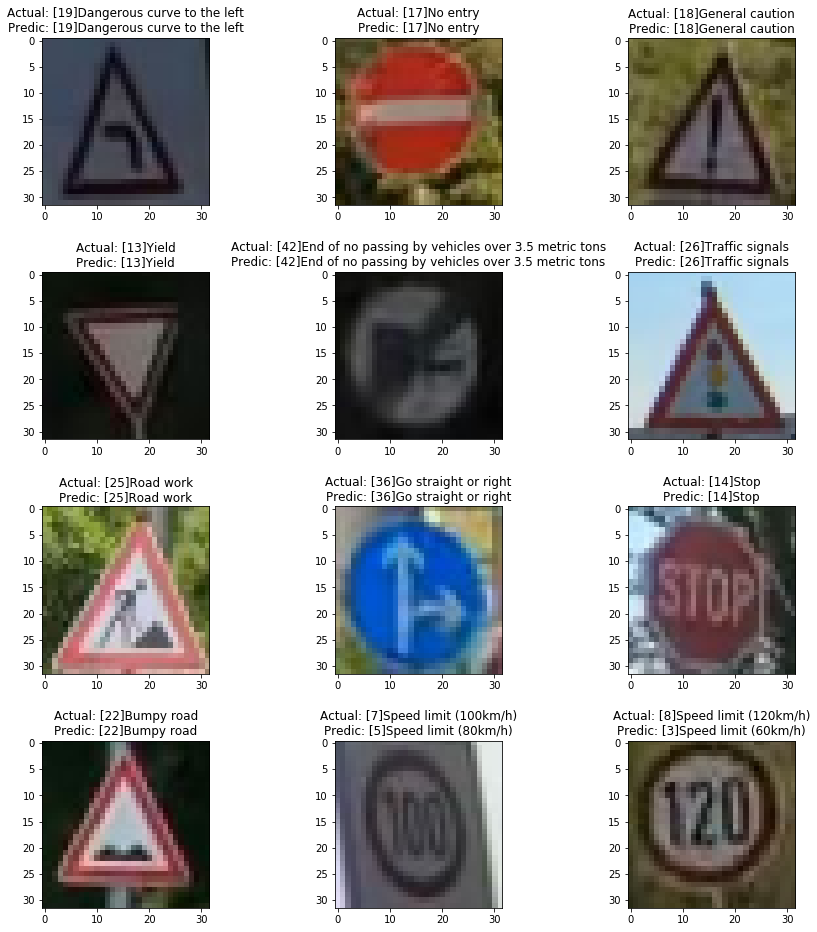

In [16]:
#print(predics)
#csfont = {'fontname':'monospace'}

fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(4*3.5, 16))
i = -1
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.5, hspace=.4)
for ax, y, image in zip(axes.flat, ys, webImgs):
    i += 1
    predClass = predics[1][i][0]
    predName = labelName[predClass]
    ax.imshow(image)
    ax.set_title('Actual: [{}]{}\nPredic: [{}]{}'.format(y,labelName[y], predClass, predName))
plt.savefig('outImages/webClassification.jpg', bbox_inches='tight')

### Output Top 5 Softmax Probabilities For Each Image Found on the Web

In [17]:
### Print out the top five softmax probabilities for the predictions on the German traffic sign images found on the web. 
for i in range(len(predics[0])):
    print('Image: {:02d}.jpg'.format(ys[i]))
    print('Probabilities:')
    for j in range(0, len(predics[0][i])):
        prob = predics[0][i][j]
        index = predics[1][i][j]
        name = labelName[index]
        print('   {:.6f} : {:2d} - {}'.format(prob, index, name))
    print()

Image: 19.jpg
Probabilities:
   1.000000 : 19 - Dangerous curve to the left
   0.000000 : 23 - Slippery road
   0.000000 : 21 - Double curve
   0.000000 : 31 - Wild animals crossing
   0.000000 :  9 - No passing

Image: 17.jpg
Probabilities:
   0.999998 : 17 - No entry
   0.000002 : 34 - Turn left ahead
   0.000000 :  9 - No passing
   0.000000 : 35 - Ahead only
   0.000000 : 14 - Stop

Image: 18.jpg
Probabilities:
   1.000000 : 18 - General caution
   0.000000 : 26 - Traffic signals
   0.000000 : 27 - Pedestrians
   0.000000 : 37 - Go straight or left
   0.000000 :  4 - Speed limit (70km/h)

Image: 13.jpg
Probabilities:
   1.000000 : 13 - Yield
   0.000000 : 12 - Priority road
   0.000000 : 35 - Ahead only
   0.000000 :  9 - No passing
   0.000000 : 15 - No vehicles

Image: 42.jpg
Probabilities:
   1.000000 : 42 - End of no passing by vehicles over 3.5 metric tons
   0.000000 :  6 - End of speed limit (80km/h)
   0.000000 : 41 - End of no passing
   0.000000 : 10 - No passing for vehi

### Project Writeup

Once you have completed the code implementation, document your results in a project writeup using this [template](https://github.com/udacity/CarND-Traffic-Sign-Classifier-Project/blob/master/writeup_template.md) as a guide. The writeup can be in a markdown or pdf file. 

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.

---

## Step 4 (Optional): Visualize the Neural Network's State with Test Images

 This Section is not required to complete but acts as an additional excersise for understaning the output of a neural network's weights. While neural networks can be a great learning device they are often referred to as a black box. We can understand what the weights of a neural network look like better by plotting their feature maps. After successfully training your neural network you can see what it's feature maps look like by plotting the output of the network's weight layers in response to a test stimuli image. From these plotted feature maps, it's possible to see what characteristics of an image the network finds interesting. For a sign, maybe the inner network feature maps react with high activation to the sign's boundary outline or to the contrast in the sign's painted symbol.

 Provided for you below is the function code that allows you to get the visualization output of any tensorflow weight layer you want. The inputs to the function should be a stimuli image, one used during training or a new one you provided, and then the tensorflow variable name that represents the layer's state during the training process, for instance if you wanted to see what the [LeNet lab's](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) feature maps looked like for it's second convolutional layer you could enter conv2 as the tf_activation variable.

For an example of what feature map outputs look like, check out NVIDIA's results in their paper [End-to-End Deep Learning for Self-Driving Cars](https://devblogs.nvidia.com/parallelforall/deep-learning-self-driving-cars/) in the section Visualization of internal CNN State. NVIDIA was able to show that their network's inner weights had high activations to road boundary lines by comparing feature maps from an image with a clear path to one without. Try experimenting with a similar test to show that your trained network's weights are looking for interesting features, whether it's looking at differences in feature maps from images with or without a sign, or even what feature maps look like in a trained network vs a completely untrained one on the same sign image.

<figure>
 <img src="visualize_cnn.png" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above)</p> 
 </figcaption>
</figure>
 <p></p> 


In [1]:
### Visualize your network's feature maps here.
### Feel free to use as many code cells as needed.

# image_input: the test image being fed into the network to produce the feature maps
# tf_activation: should be a tf variable name used during your training procedure that represents the calculated state of a specific weight layer
# activation_min/max: can be used to view the activation contrast in more detail, by default matplot sets min and max to the actual min and max values of the output
# plt_num: used to plot out multiple different weight feature map sets on the same block, just extend the plt number for each new feature map entry

def outputFeatureMap(image_input, tf_activation, activation_min=-1, activation_max=-1 ,plt_num=1):
    # Here make sure to preprocess your image_input in a way your network expects
    # with size, normalization, ect if needed
    # image_input =
    # Note: x should be the same name as your network's tensorflow data placeholder variable
    # If you get an error tf_activation is not defined it may be having trouble accessing the variable from inside a function
    activation = tf_activation.eval(session=sess,feed_dict={x : image_input})
    featuremaps = activation.shape[3]
    plt.figure(plt_num, figsize=(15,15))
    for featuremap in range(featuremaps):
        plt.subplot(6,8, featuremap+1) # sets the number of feature maps to show on each row and column
        plt.title('FeatureMap ' + str(featuremap)) # displays the feature map number
        if activation_min != -1 & activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin =activation_min, vmax=activation_max, cmap="gray")
        elif activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmax=activation_max, cmap="gray")
        elif activation_min !=-1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin=activation_min, cmap="gray")
        else:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", cmap="gray")